<a href="https://colab.research.google.com/github/86lekwenshiung/West-Nile-Virus-Prediction/blob/main/West_Nile_Virus_Classification_Modelling_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# West Nile Virus Classification Modelling (Part 2 of 2)
___

<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/image/rossmann-westnile.jpg' width = 75%>
<p/>
Source : https://www.purdue.edu/uns/html4ever/2006/060814.Rossmann.westnile.html


**Problem Statement**

West Nile virus (WNV) is a single-stranded RNA virus that causes West Nile fever. It is a member of the family Flaviviridae, from the genus Flavivirus, which also contains the Zika virus, dengue virus, and yellow fever virus. The virus is primarily transmitted by mosquitoes, mostly species of Culex. It has been causing significant and sometimes severe human diseases. Although pesticides are known to be effective in dealing with the virus-carrying mosquitoes, it is expensive to deploy pesticides throughout the city.

As data scientists, we want to understand the factors driving the spread of WNV by leveraging on data collected by Chicago's surveillance system, weather stations, and pesticide spray deployment, in order to develop a classfication model that could predict the presence of WNV within the area of the city. Through these studies, we hope to suggest a cost-efficient and effective method of deploying pesticides within the area.

**Model Explored**

|Models|Description|
|---|---|
|Random Forest Classifier|With & Without Smote|
|Gradient Boosting Classifier|With & Without Smote|
|XGB Classifier|With & Without Smote|

**Evaluation Metrics**

`Since this is a classification model , we will evaluate how will our model will perform in classifying between a the presence of Wnv. Depending on the preprocessing method, different evaluation metric will be used accordingly.`
  * `For Imbalanced Data : F1 Score , Precision , AUC`
  * `For Balanced Data : F1 Score , Accuracy`
  * `Others Metrics : Recall Score`

**Workflow Process**  
1. Notebook 1 of 2 : General EDA
2. Notebook 1 of 2 : EDA on Geolocation
3. Notebook 2 of 2 : Data Preprocessing
4. Notebook 2 of 2 : Feature Engineering
5. Notebook 2 of 2 : Create Model
6. Notebook 2 of 2 : Processing Dataframe for Kaggle Submission
7. Notebook 2 of 2 : Cost Benefit Analysis


# 0.0 Libraries Import
___

In [37]:
# General Utilities
import datetime
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plot-metric
from plot_metric.functions import BinaryClassification

from geopy.distance import geodesic
import shapely
from shapely.geometry import Point , MultiPoint
from shapely.ops import nearest_points

# Machine Learning Libraries
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix , plot_roc_curve
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1.0 Data Import
___

In [38]:
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/test.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/spray.csv

--2021-11-06 02:34:13--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797335 (1.7M) [text/plain]
Saving to: ‘train.csv.3’

train.csv.3         100%[===================>]   1.71M  --.-KB/s    in 0.06s   

2021-11-06 02:34:14 (30.8 MB/s) - ‘train.csv.3’ saved [1797335/1797335]

--2021-11-06 02:34:14--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [39]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_spray = pd.read_csv('/content/spray.csv')
df_weather = pd.read_csv('/content/weather.csv')

#2.0 Feature Creation & Data Preprocessing
___

In [40]:
# Function to preprocess date

def preprocess_date(df):
  df['Year'] = pd.to_datetime(df['Date']).dt.year
  df['Month'] = pd.to_datetime(df['Date']).dt.month
  df['WeekofYear'] = pd.to_datetime(df['Date']).dt.isocalendar().week

  return df

In [41]:
# Preprocess Dataframe

def preprocess_df(df):
  # df['NumMosquitos'] = df['NumMosquitos'].fillna(0)
  # df['WnvPresent'] = df['WnvPresent'].fillna(0)
  df['Species'] = df['Species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1}) \
                                   .fillna(0)

  df['Trap'] = df['Trap'].astype('category').cat.codes
  df.isin(['-']).sum()[df.isin(['-']).sum() > 0].sort_values(ascending=False)
  df['Sunrise'] = np.where(df['Sunrise'].isin(['-']), 0 ,df['Sunrise'])
  df['Sunset'] = np.where(df['Sunset'].isin(['-']), 0 ,df['Sunset'])
  df['WetBulb'] = np.where(df['Sunset'].isin(['-']) , 0 , df['WetBulb'])
  df['WetBulb'] = np.where(df['WetBulb'].isin(['M']) , df['WetBulb'].mode() , df['WetBulb'])

  df['WetBulb'] = df['WetBulb'].astype('int')
  df['Sunrise'] = df['Sunrise'].astype('int')
  df['Sunset'] = df['Sunset'].astype('int')

  return df                                     

In [42]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_smote, y_train_smote)
        pipe = gs
        
    else:
        pipe.fit(X_train_smote, y_train_smote)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train_smote)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train_smote, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [43]:
def evaluation_plot(model,prediction_list,proba_list):
  
  train_pred,test_pred = prediction_list
  train_proba,test_proba = proba_list

  plt.figure(figsize=(24,12))

  bc = BinaryClassification(y_train_smote, train_proba[::,1], labels=["WNV-", "WNV+"])
  bc1 = BinaryClassification(y_test, test_proba[::,1], labels=["WNV-", "WNV+"])

  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')

  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')

  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')

  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)

  #plot class distribution
  plt.subplot2grid((3,12), (2,3), colspan=3)
  bc.plot_class_distribution(title ='Training -Class Distribution')
  plt.subplot2grid((3,12), (2,6), colspan=3)
  bc1.plot_class_distribution(title = 'Testing - Class Distribution')
  plt.show()  
  # bc.print_report()

In [44]:
def predictions(pipeline):
    #fit pipeline to training data
    pipeline.fit(X_train_smote,y_train_smote) 

    a = [pipeline.predict(X_train_smote), pipeline.predict(X_test)]
    b = [pipeline.predict_proba(X_train_smote), pipeline.predict_proba(X_test)]
    return a,b

In [45]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

### 2.1 Date Features
___

In [46]:
df_train = preprocess_date(df_train)
df_spray = preprocess_date(df_spray)
df_weather = preprocess_date(df_weather)

In [47]:
df_spray[df_spray.duplicated()].head()

,Date,Time,Latitude,Longitude,Year,Month,WeekofYear
485,2011-09-07,7:43:40 PM,41.983917,-87.793088,2011,9,36
490,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36
491,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36
492,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36
493,2011-09-07,7:44:32 PM,41.986460,-87.794225,2011,9,36


In [48]:
# Drop off Time from df_spray
# Drop off duplicate from df_spray

df_spray.drop('Time' , axis  = 1 , inplace = True)
df_spray.drop_duplicates(keep = 'first' , inplace = True)

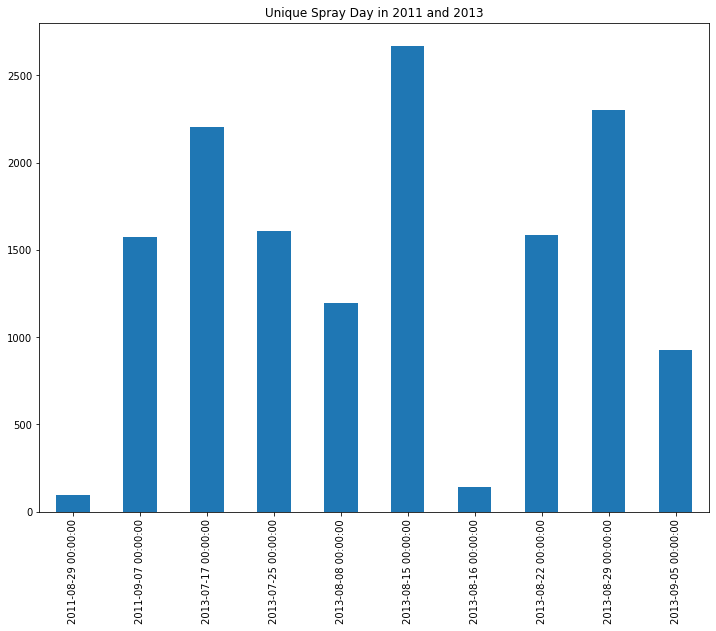

In [49]:
df_spray['Date'].astype('datetime64').value_counts().sort_index().plot(kind = 'bar' , figsize = (12,9))
plt.title('Unique Spray Day in 2011 and 2013');

### 2.2 Spray Cluster
___

In [50]:
# Create trap coordinate 
df_train['trap coordinate'] = [Point(x,y) for x,y in zip(df_train['Latitude'] , df_train['Longitude'])]

# Create Spray coordinate
df_spray['spray coordinate'] = [Point(x,y) for x,y in zip(df_spray['Latitude'] , df_spray['Longitude'])]

# Convert spray coodinate to multipoint
spray_coord = MultiPoint(df_spray['spray coordinate'].to_list())

In [51]:
dist = []

for trap_coord in df_train['trap coordinate']:

  nearest = nearest_points(trap_coord , spray_coord)

  a , b = (trap_coord.x , trap_coord.y) , (nearest[1].x , nearest[1].y)

  dist.append(geodesic(a,b).m)

# add distance to trap locations
df_train['dist_spray'] = dist
df_train['sprayed'] = df_train['dist_spray'].apply(lambda x: 0 if x > 1000 else 1)

In [52]:
df_train['sprayed'].value_counts()

0    7089
1    3417
Name: sprayed, dtype: int64

In [53]:
# Any spray distance within 1000m radius of the trap is considered sprayed
df_train.head()[['trap coordinate' , 'dist_spray' , 'sprayed']]

,trap coordinate,dist_spray,sprayed
0,POINT (41.95469 -87.800991),255.770357,1
1,POINT (41.95469 -87.800991),255.770357,1
2,POINT (41.994991 -87.769279),347.488585,1
3,POINT (41.974089 -87.82481199999999),11.224465,1
4,POINT (41.974089 -87.82481199999999),11.224465,1


### 2.3 Weather Feature
___

In [54]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WeekofYear
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,5,18
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6,2007,5,18
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,5,18
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4,2007,5,18
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,5,18


In [55]:
# replace trace and missing precip with 0s
df_weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
df_weather.PrecipTotal = df_weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(df_weather.Tavg.value_counts()['M'])

# imputing Tavg manually (increases accuracy)
df_weather.Tavg = (df_weather.Tmax + df_weather.Tmin)/2
df_weather.Tavg = df_weather.Tavg.astype(float)

11


In [56]:
# Consider only taking Station 2 in the analysis
df_weather = df_weather[df_weather['Station'] == 2]

In [57]:
print('DF train shape before merge :' ,  df_train.shape)
print('DF weather shape :' ,  df_weather.shape)

df_train = pd.merge(df_train, df_weather , on=['Date', 'Year', 'WeekofYear', 'Month'] , how = 'left')

print('DF train shape after merge:' ,  df_train.shape)

DF train shape before merge : (10506, 18)
DF weather shape : (1472, 25)
DF train shape after merge: (10506, 39)


# 3.0 Preprocessing Dataframe
___

* 3.1. We will drop redundant columns
* 3.2. We will map and preprocess (dummy , label encoder) the columns
* 3.3. Split the Dataset


### 3.1 Dropping Redundant Col
___

In [58]:
print('No. of columns before drop :' , len(df_train.columns))

df_train.drop(['AddressAccuracy','Address','Street','AddressNumberAndStreet'],axis=1,inplace=True)
df_train.drop(['Water1','Depart','Depth','SnowFall','AvgSpeed','ResultSpeed','ResultDir','SeaLevel','StnPressure','CodeSum','Heat','Cool'],axis=1,inplace=True)
df_train.drop(['trap coordinate'],axis=1,inplace=True)

print('No. of columns after drop :' , len(df_train.columns))

No. of columns before drop : 39
No. of columns after drop : 22


In [59]:
df_train.columns

Index(['Date', 'Species', 'Block', 'Trap', 'Latitude', 'Longitude',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'WeekofYear',
       'dist_spray', 'sprayed', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint',
       'WetBulb', 'Sunrise', 'Sunset', 'PrecipTotal'],
      dtype='object')

### 3.2 Preprocessing Dataframe
___

In [60]:
df_train_processed = preprocess_df(df_train)

### 3.3 Splitting Dataset
___

In [61]:
X = df_train_processed.drop(['Date','WnvPresent' , 'NumMosquitos', 'dist_spray'], axis=1)
y = df_train_processed['WnvPresent']

Text(0.5, 1.0, 'WnvPresent Percentage')

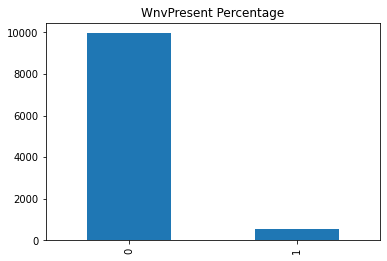

In [62]:
y.value_counts().plot(kind = 'bar');
plt.title('WnvPresent Percentage')

# 4.0 Classification Modelling with SMOTE & No SMOTE
___

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [64]:
X_train_smote, y_train_smote = X_train , y_train

### 4.1 Modelling With No Smote
___

In [65]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'xgb': XGBClassifier(random_state=42),
        }

In [66]:
gb = run_model('gb')
print('-------------------------------')
rfc = run_model('rf')
print('-------------------------------')
xgb = run_model('xgb')

### METRICS ###


{'f_score': 0.0,
 'model': 'gb',
 'precision': 0.0,
 'recall': 0.0,
 'specificity': 0.998995983935743,
 'test_auc': 0.834848484848485,
 'train_auc': 0.8954608089625402}

True Negatives: 1990
False Positives: 2
False Negatives: 110
True Positives: 0
-------------------------------
### METRICS ###


{'f_score': 0.26373626373626374,
 'model': 'rf',
 'precision': 0.3333333333333333,
 'recall': 0.21818181818181817,
 'specificity': 0.9759036144578314,
 'test_auc': 0.756722343921139,
 'train_auc': 0.9850487643673987}

True Negatives: 1944
False Positives: 48
False Negatives: 86
True Positives: 24
-------------------------------
### METRICS ###


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f_score': 0.0,
 'model': 'xgb',
 'precision': 0.0,
 'recall': 0.0,
 'specificity': 1.0,
 'test_auc': 0.8343145308506754,
 'train_auc': 0.8858531649923983}

True Negatives: 1992
False Positives: 0
False Negatives: 110
True Positives: 0


In [67]:
model_result_no_smote = pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

In [68]:
model_result_no_smote['model'].replace({'gb' : 'gb_NoSmote',
                                        'xgb' : 'xgb_NoSmote',
                                        'rf' : 'rf_NoSmote'}, inplace = True)
model_result_no_smote

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,gb_NoSmote,0.895461,0.834848,0.000000,0.998996,0.000000,0.000000
1,xgb_NoSmote,0.885853,0.834315,0.000000,1.000000,0.000000,0.000000
2,rf_NoSmote,0.985049,0.756722,0.333333,0.975904,0.218182,0.263736


### 4.2 Modelling With SMOTEENN
___

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [70]:
# borderline-SMOTE with SVM for imbalanced dataset
from collections import Counter
from imblearn.combine import SMOTEENN
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
smote = SMOTEENN()

Counter({0: 9955, 1: 551})


In [71]:
X_train_smote, y_train_smote = smote.fit_sample(X = X_train,y = y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [72]:
print('Before SMOTE :', np.bincount(y_train))
print('After SMOTE :', np.bincount(y_train_smote))

Before SMOTE : [7963  441]
After SMOTE : [6457 6808]


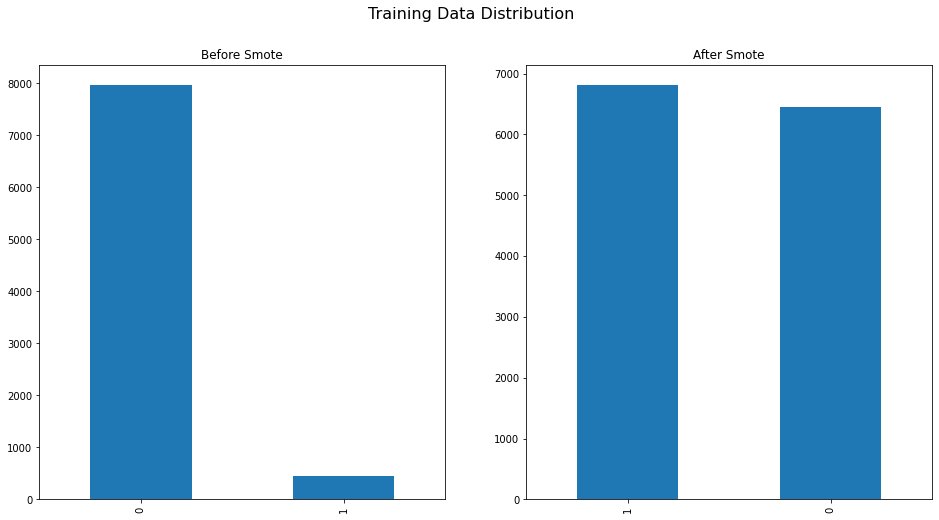

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2 , figsize = (16,8))

plt.suptitle('Training Data Distribution' , fontsize = 16)

y_train.value_counts().plot(kind = 'bar' , ax= axes[0])
axes[0].set_title('Before Smote')

pd.Series(y_train_smote).value_counts().plot(kind = 'bar' , ax= axes[1])
axes[1].set_title('After Smote');

#### 4.2.1 Gradient Boosting Classifier
___

### METRICS ###


{'f_score': 0.2623655913978495,
 'model': 'gb',
 'precision': 0.17183098591549295,
 'recall': 0.5545454545454546,
 'specificity': 0.8524096385542169,
 'test_auc': 0.8176478641840087,
 'train_auc': 0.991552529915429}

True Negatives: 1698
False Positives: 294
False Negatives: 49
True Positives: 61


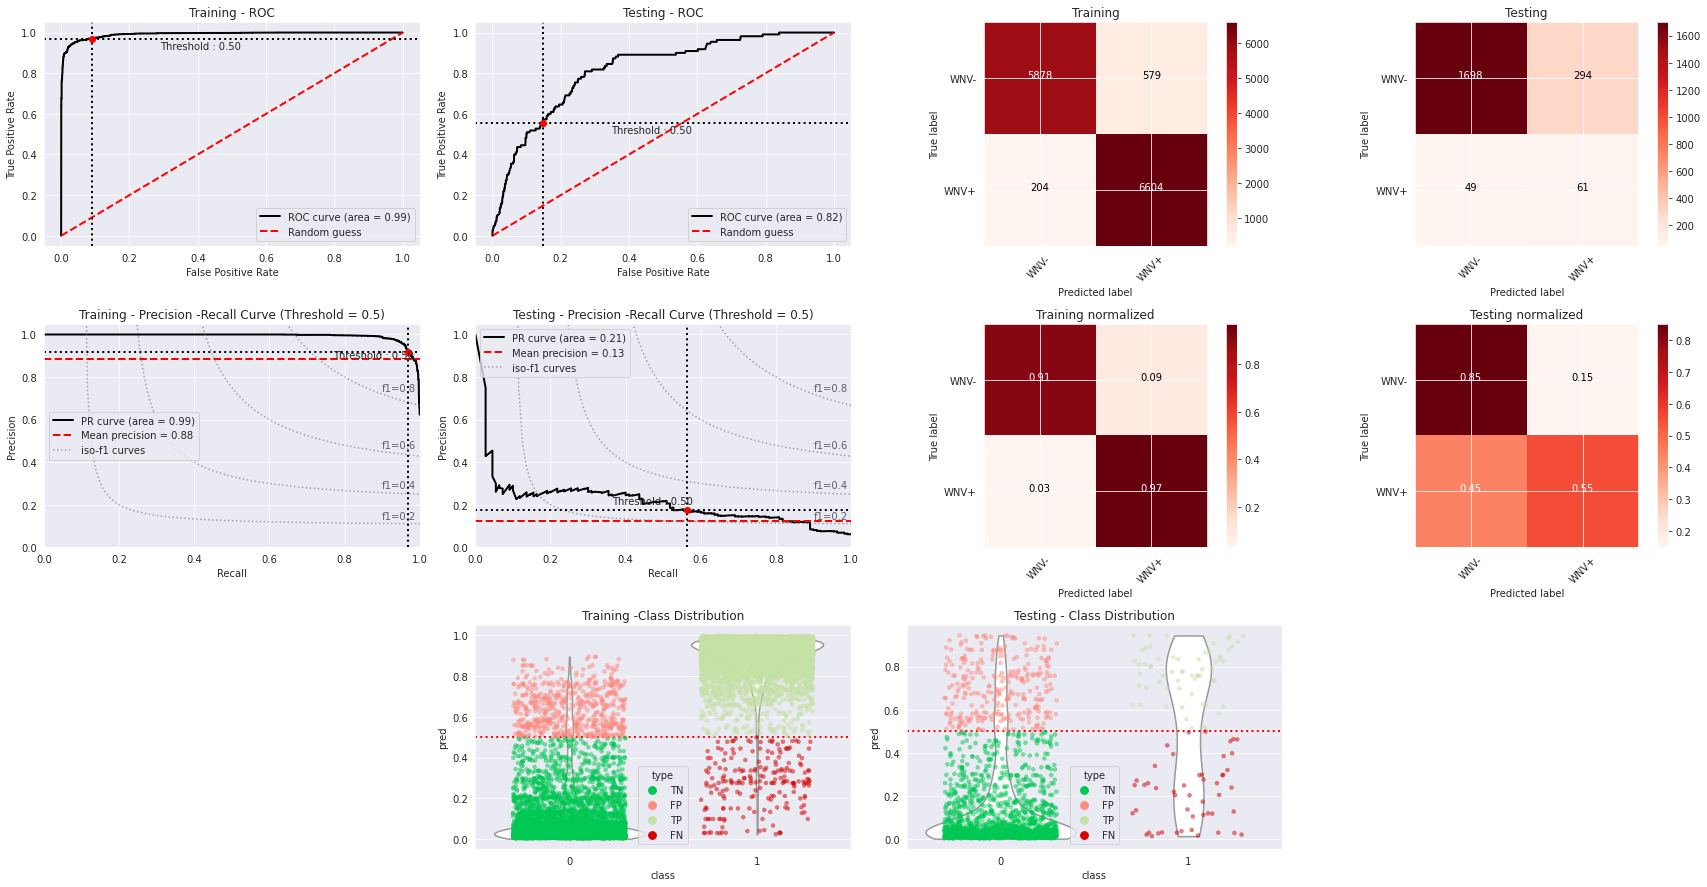

In [74]:
gb_smote = run_model('gb' , grid_search = False)
prediction_list,proba_list= predictions(gb_smote)
evaluation_plot(gb_smote, prediction_list,proba_list)

#### 4.2.2 Random Forest Classifier
___

### METRICS ###


{'f_score': 0.26973684210526316,
 'model': 'rf',
 'precision': 0.211340206185567,
 'recall': 0.37272727272727274,
 'specificity': 0.9231927710843374,
 'test_auc': 0.7269236035049288,
 'train_auc': 1.0}

True Negatives: 1839
False Positives: 153
False Negatives: 69
True Positives: 41


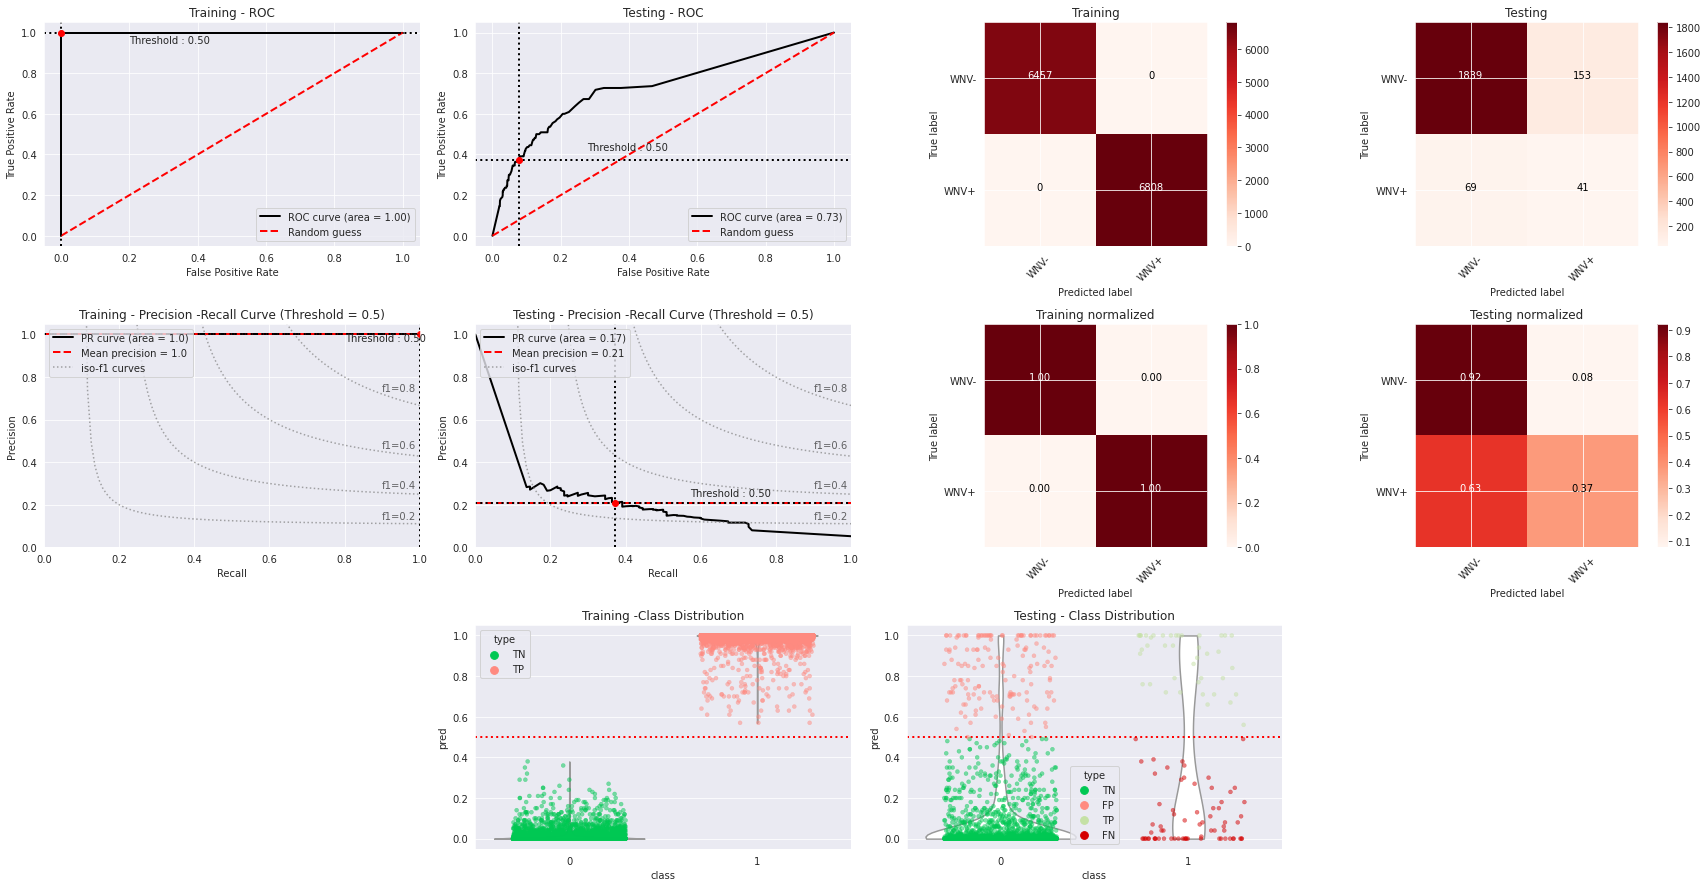

In [75]:
rf_smote = run_model('rf' , grid_search = False)
prediction_list,proba_list= predictions(rf_smote)
evaluation_plot(rf_smote, prediction_list,proba_list)

#### 4.2.3 XGB Classifier
___

### METRICS ###


{'f_score': 0.2652631578947368,
 'model': 'xgb',
 'precision': 0.1726027397260274,
 'recall': 0.5727272727272728,
 'specificity': 0.8483935742971888,
 'test_auc': 0.8238545089448703,
 'train_auc': 0.9916303519786595}

True Negatives: 1690
False Positives: 302
False Negatives: 47
True Positives: 63


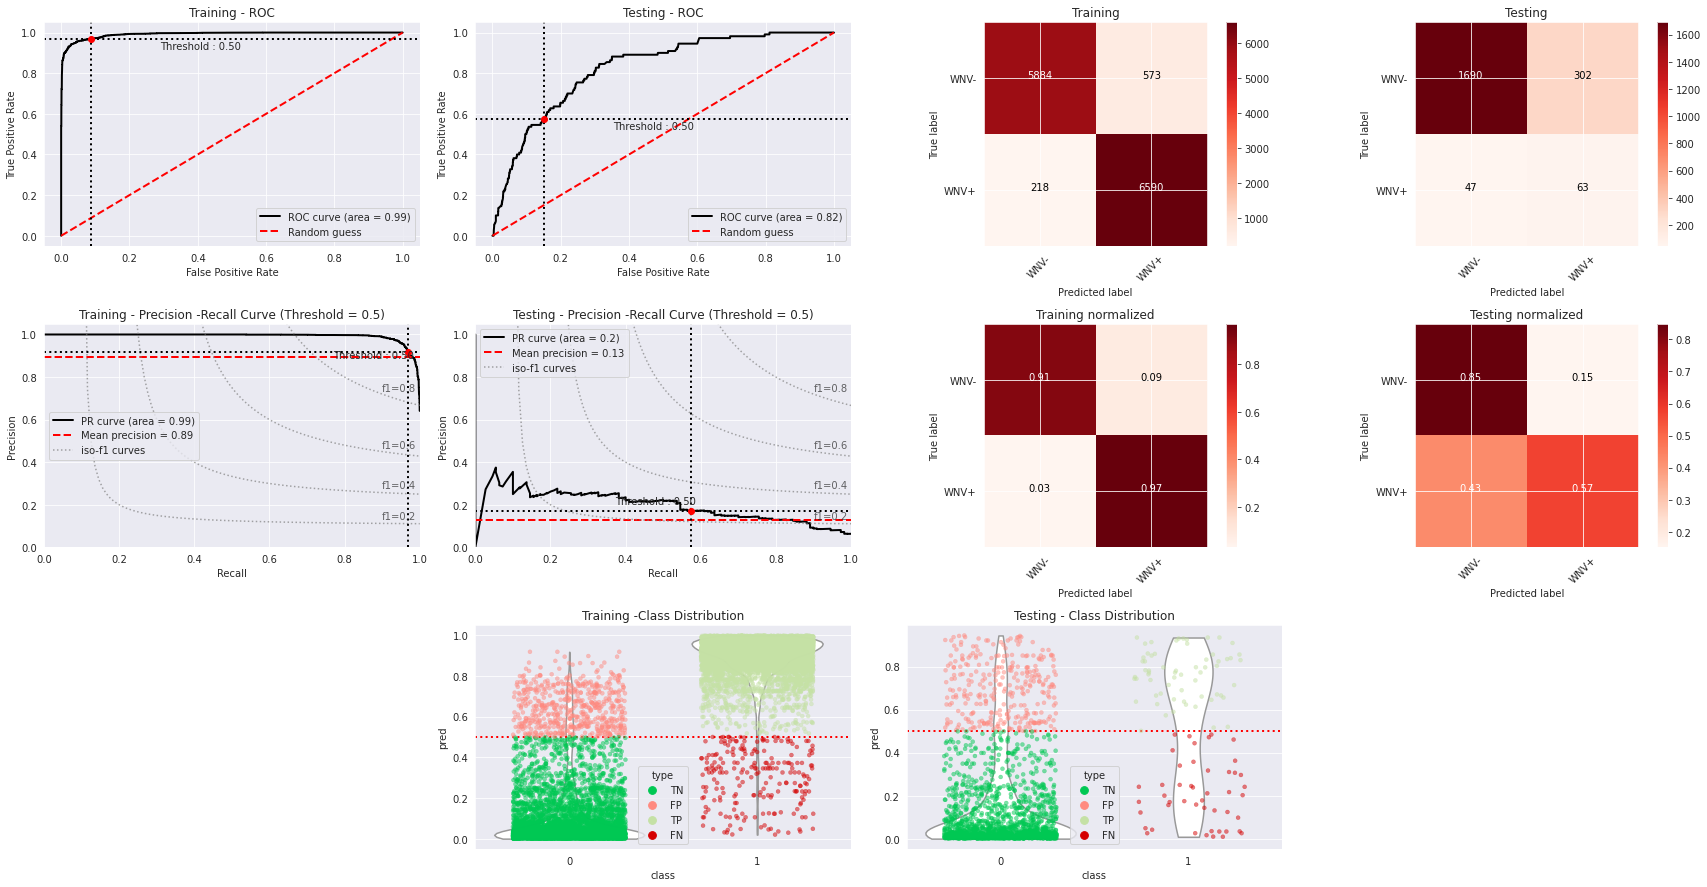

In [76]:
xgb_smote = run_model('xgb' , grid_search = False)
prediction_list,proba_list= predictions(xgb_smote)
evaluation_plot(xgb_smote, prediction_list,proba_list)

### 4.3 Summary Result
___

In [77]:
model_result_smote = pd.DataFrame(init_list).sort_values(by='model').reset_index(drop=True)

In [78]:
model_result_smote

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,gb,0.895461,0.834848,0.000000,0.998996,0.000000,0.000000
1,gb,0.991553,0.817648,0.171831,0.852410,0.554545,0.262366
2,rf,0.985049,0.756722,0.333333,0.975904,0.218182,0.263736
3,rf,1.000000,0.726924,0.211340,0.923193,0.372727,0.269737
4,xgb,0.885853,0.834315,0.000000,1.000000,0.000000,0.000000
5,xgb,0.991630,0.823855,0.172603,0.848394,0.572727,0.265263


In [79]:
init_dict = {
    gb_smote: 'GradientBoostingClassifier',
    rf_smote: 'RandomForest',
    xgb_smote: 'XGBoostingClassifier',
}

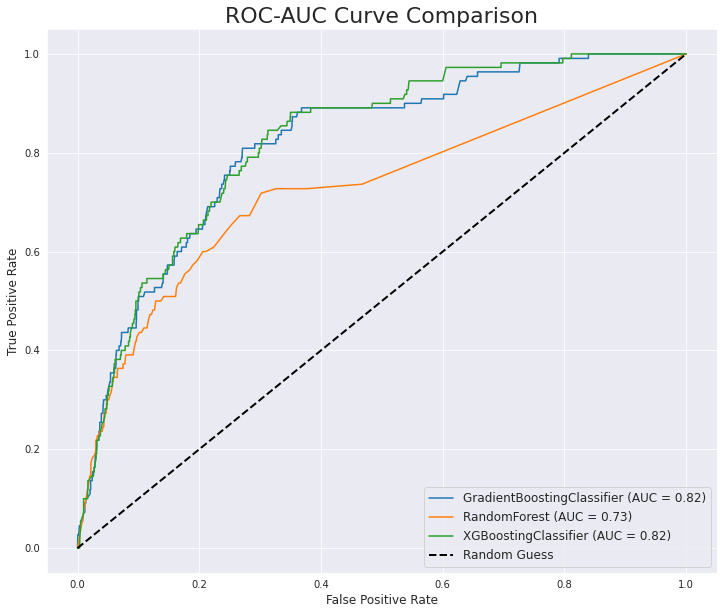

In [80]:
roc_curve_plotter(init_dict)

# 5.0 Preprocess test Data
___

In [81]:
df_test = pd.read_csv('/content/test.csv')
df_test = preprocess_date(df_test)

df_test = pd.merge(df_test, df_weather , on=['Date', 'Year', 'WeekofYear', 'Month'] , how = 'left')
df_test.drop(['AddressAccuracy','Address','Street','AddressNumberAndStreet'],axis=1,inplace=True)
df_test.drop(['Water1','Depart','Depth','SnowFall','AvgSpeed','ResultSpeed','ResultDir','SeaLevel','StnPressure','CodeSum','Heat','Cool'],axis=1,inplace=True)
df_test['sprayed'] = 0

In [82]:
df_test_processed = preprocess_df(df_test)

In [83]:
df_test_processed_id = df_test_processed['Id']
X_test = df_test_processed.drop(['Id' , 'Date'] , axis = 1)
X_test.shape , X_train.shape

((116293, 18), (8404, 18))

In [84]:
X_test.head()

,Species,Block,Trap,Latitude,Longitude,Year,Month,WeekofYear,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,sprayed
0,2.0,41,1,41.95469,-87.800991,2008,6,24,2,86,66,76.0,55,64,0,0,0.0,0
1,1.0,41,1,41.95469,-87.800991,2008,6,24,2,86,66,76.0,55,64,0,0,0.0,0
2,2.0,41,1,41.95469,-87.800991,2008,6,24,2,86,66,76.0,55,64,0,0,0.0,0
3,0.0,41,1,41.95469,-87.800991,2008,6,24,2,86,66,76.0,55,64,0,0,0.0,0
4,0.0,41,1,41.95469,-87.800991,2008,6,24,2,86,66,76.0,55,64,0,0,0.0,0


In [85]:
model = XGBClassifier(random_state = 42)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test.to_numpy())

In [86]:
df_submission = pd.DataFrame({'Id' : df_test_processed_id,
                              'WnvPresent' : y_pred})

df_submission.to_csv(path_or_buf = 'df_submission.csv' , index = False)

# 6.0 Cost Benefit Analysis
___

* Costs 
  - Using pesticide Zenivex E4 , based on estimates of \$500 for a session for 0.5 acre of land , Cost is \$149,000 for 0.6 km^2.
* Benefits:
  - Fewer people dying/falling ill —> increased workplace productivity and healthcare savings (average \$11,000)
  - 108 WNV cases in 2016: medical bill of \$990,000
* Recommendation :
  - Since the benefits outweigh the costs the county should socialise the cost and share the prevention costs with the community as a whole.



References :
* [1. Pesticide info](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox)
* [2. Cost of spray](https://www.callnorthwest.com/2020/05/how-much-does-a-mosquito-treatment-cost/)

* [3. Chicago spray strategy](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html)

* [4. WNV cost](https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-019-4596-9)


In [97]:
# cost per km^2
sp_cost = 500/.00202*.6
print(f'it costs $500 per 0.00202 km^2 to spray, so it will cost ${sp_cost:,.2f} per 0.6km^2')

# cost of care mean attributable 1-year cost CAD 13,648 USD 11006.43
print(f'cost of care for 108 patients ${11006.43*108:,.2f}')

it costs $500 per 0.00202 km^2 to spray, so it will cost $148,514.85 per 0.6km^2
cost of care for 108 patients $1,188,694.44


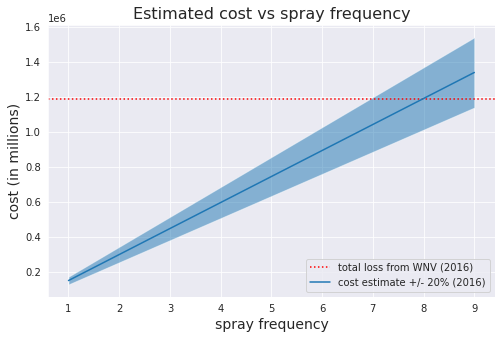

In [99]:
max_frequency = 10

plt.figure(figsize=(8,5))

x_value = np.arange(1, max_frequency)
y_value = np.arange(1, max_frequency) * 149_000
bandwidth = np.arange(1, max_frequency) * 149_000*.3

plt.fill_between(x_value, y_value+bandwidth/2, y_value-bandwidth/2, alpha=.5)
plt.axhline(1_188_000, color='r', linestyle=':', label = 'total loss from WNV (2016)')
plt.plot(x_value,y_value, label='cost estimate +/- 20% (2016)')
plt.title('Estimated cost vs spray frequency', fontsize=16)
plt.xlabel('spray frequency', fontsize=14)
plt.ylabel('cost (in millions)', fontsize=14)
plt.legend(loc=4)
plt.show();